In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tuannguyenvananh/pokemon-dataset-with-team-combat")

print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pokemon = pd.read_csv('pokemon.csv', encoding='latin1')
combat = pd.read_csv('combats.csv', encoding='latin1')

#Normalize numeric values
names = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for col in names:
    pokemon[col] = (pokemon[col] - pokemon[col].min()) / (pokemon[col].max() - pokemon[col].min())

pokemon = pd.get_dummies(pokemon, columns=['Type 1', ], dtype=int)
pokemon = pd.get_dummies(pokemon, columns=['Type 2', ], dtype=int)

#Dropping Features and encoding True/False
pokemon = pokemon.drop('Name', axis=1)
# pokemon = pokemon.drop('Type 2', axis=1) #Dropping type2 to reduce dimensionality of the data
pokemon = pokemon.drop('Generation', axis=1)
pokemon['Legendary'] = pokemon['Legendary'].astype(int)
y = combat['Winner']
combat=combat.drop('Winner', axis=1)

In [2]:
# Encode y as true or false. True if the first pokemon wins and false if the second pokemon wins.
for i in range(len(combat)):
    if y[i] == combat['First_pokemon'][i]:
        y[i]=1
    else:
        y[i]=0

In [3]:
cols = pokemon.drop('#', axis=1).columns
merged1 = combat.merge(pokemon, left_on='First_pokemon', right_on='#', how='left')
merged1 = merged1.drop(columns=['#'])
merged1.columns = ['First_pokemon', 'Second_pokemon'] + [col + '1' for col in cols]

# Step 3: Merge with pokemon data for Second_pokemon
merged2 = merged1.merge(pokemon, left_on='Second_pokemon', right_on='#', how='left')
merged2 = merged2.drop(columns=['#', 'First_pokemon', 'Second_pokemon'])
merged2.columns = merged1.columns.tolist()[2:] + [col + '2' for col in cols]

# Final DataFrame
df = merged2
# df.head()

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [10]:
model = MLPClassifier(random_state=42, solver='sgd',learning_rate_init=0.005)
model.fit(X_train, y_train)

model.predict(X_test)

model1_accuracy = model.score(X_test, y_test)
print(f"Initial accuracy using 'sgd': {model1_accuracy}")

model2 = MLPClassifier(random_state=42, solver='adam',learning_rate_init=0.005)
model2.fit(X_train, y_train)

model2.predict(X_test)

model2_accuracy = model2.score(X_test, y_test)
print(f"Initial accuracy using 'adam': {model2_accuracy}")

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Initial accuracy using 'sgd': 0.9269
Initial accuracy using 'adam': 0.9541


For large datasets, the "solver" used could either be 'sgd' (Stochastic Gradient Descent) or 'adam' (a Stochastic Gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba). 'adam' seems to both converge faster and achieve higher accuracy, so we will use 'adam' for hyperparameter tuning.

This matches sklearn's recommendations for model tuning: https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py

In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['relu', 'logistic', 'tanh'],
    'max_iter': [200, 400]
}

# perform grid search with cross-validation
grid_search = GridSearchCV(MLPClassifier(solver='adam', learning_rate_init=0.005), param_grid, cv=2, verbose=3)
grid_result = grid_search.fit(X_train, y_train)

# print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

Fitting 2 folds for each of 18 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END activation=relu, hidden_layer_sizes=(50,), max_iter=200;, score=0.935 total time=  21.3s
[CV 2/2] END activation=relu, hidden_layer_sizes=(50,), max_iter=200;, score=0.927 total time=  11.1s
[CV 1/2] END activation=relu, hidden_layer_sizes=(50,), max_iter=400;, score=0.935 total time=  12.5s
[CV 2/2] END activation=relu, hidden_layer_sizes=(50,), max_iter=400;, score=0.926 total time=  13.6s
[CV 1/2] END activation=relu, hidden_layer_sizes=(100,), max_iter=200;, score=0.930 total time=  24.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END activation=relu, hidden_layer_sizes=(100,), max_iter=200;, score=0.930 total time=  32.0s
[CV 1/2] END activation=relu, hidden_layer_sizes=(100,), max_iter=400;, score=0.927 total time=  24.3s
[CV 2/2] END activation=relu, hidden_layer_sizes=(100,), max_iter=400;, score=0.926 total time=  23.5s
[CV 1/2] END activation=relu, hidden_layer_sizes=(150,), max_iter=200;, score=0.929 total time=  29.2s
[CV 2/2] END activation=relu, hidden_layer_sizes=(150,), max_iter=200;, score=0.927 total time=  25.0s
[CV 1/2] END activation=relu, hidden_layer_sizes=(150,), max_iter=400;, score=0.929 total time=  33.6s
[CV 2/2] END activation=relu, hidden_layer_sizes=(150,), max_iter=400;, score=0.920 total time=  25.1s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END activation=logistic, hidden_layer_sizes=(50,), max_iter=200;, score=0.935 total time=  14.8s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END activation=logistic, hidden_layer_sizes=(50,), max_iter=200;, score=0.934 total time=  14.6s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END activation=logistic, hidden_layer_sizes=(50,), max_iter=400;, score=0.934 total time=  28.7s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END activation=logistic, hidden_layer_sizes=(50,), max_iter=400;, score=0.929 total time=  30.2s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END activation=logistic, hidden_layer_sizes=(100,), max_iter=200;, score=0.933 total time=  36.0s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END activation=logistic, hidden_layer_sizes=(100,), max_iter=200;, score=0.933 total time=  37.2s
[CV 1/2] END activation=logistic, hidden_layer_sizes=(100,), max_iter=400;, score=0.934 total time= 1.1min
[CV 2/2] END activation=logistic, hidden_layer_sizes=(100,), max_iter=400;, score=0.930 total time= 1.0min


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END activation=logistic, hidden_layer_sizes=(150,), max_iter=200;, score=0.930 total time=  47.1s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END activation=logistic, hidden_layer_sizes=(150,), max_iter=200;, score=0.935 total time=  45.5s
[CV 1/2] END activation=logistic, hidden_layer_sizes=(150,), max_iter=400;, score=0.933 total time= 1.4min
[CV 2/2] END activation=logistic, hidden_layer_sizes=(150,), max_iter=400;, score=0.932 total time= 1.3min


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END activation=tanh, hidden_layer_sizes=(50,), max_iter=200;, score=0.928 total time=  13.2s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END activation=tanh, hidden_layer_sizes=(50,), max_iter=200;, score=0.930 total time=  12.8s
[CV 1/2] END activation=tanh, hidden_layer_sizes=(50,), max_iter=400;, score=0.927 total time=  16.2s
[CV 2/2] END activation=tanh, hidden_layer_sizes=(50,), max_iter=400;, score=0.928 total time=  20.5s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END activation=tanh, hidden_layer_sizes=(100,), max_iter=200;, score=0.929 total time=  26.6s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END activation=tanh, hidden_layer_sizes=(100,), max_iter=200;, score=0.929 total time=  27.2s
[CV 1/2] END activation=tanh, hidden_layer_sizes=(100,), max_iter=400;, score=0.933 total time=  32.0s
[CV 2/2] END activation=tanh, hidden_layer_sizes=(100,), max_iter=400;, score=0.926 total time=  27.8s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/2] END activation=tanh, hidden_layer_sizes=(150,), max_iter=200;, score=0.929 total time=  32.7s


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/2] END activation=tanh, hidden_layer_sizes=(150,), max_iter=200;, score=0.933 total time=  34.4s
[CV 1/2] END activation=tanh, hidden_layer_sizes=(150,), max_iter=400;, score=0.932 total time=  42.6s
[CV 2/2] END activation=tanh, hidden_layer_sizes=(150,), max_iter=400;, score=0.928 total time=  36.1s
Best: 0.934725 using {'activation': 'logistic', 'hidden_layer_sizes': (50,), 'max_iter': 200}
0.930750 (0.004100) with: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'max_iter': 200}
0.930725 (0.004625) with: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'max_iter': 400}
0.930075 (0.000425) with: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'max_iter': 200}
0.926525 (0.000625) with: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'max_iter': 400}
0.928425 (0.000925) with: {'activation': 'relu', 'hidden_layer_sizes': (150,), 'max_iter': 200}
0.924400 (0.004450) with: {'activation': 'relu', 'hidden_layer_sizes': (150,), 'max_iter': 400}
0.934725 (0.000625) wit

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


The best model ended up using the 'logistic' activation function, with 1 hidden layer, 50 neurons, and a max iteration of 200. However, it is concerning that the accuracy score of 0.934725 is actually lower than the 0.9541 score from the initial model.

However, since these models were under k-fold cross validation of '2', it would make sense to re-evaluate the logistic function again and compare it to the initial model.

In [6]:
model1 = MLPClassifier(random_state=42, solver='adam',learning_rate_init=0.005)
model1.fit(X_train, y_train)

model1.predict(X_test)

model1_accuracy = model1.score(X_test, y_test)
print(f"Accuracy of initial model: {model1_accuracy}")

model2 = MLPClassifier(random_state=42, solver='adam', activation='logistic', learning_rate_init=0.005, hidden_layer_sizes=(50,))
model2.fit(X_train, y_train)

model2.predict(X_test)

model2_accuracy = model2.score(X_test, y_test)
print(f"Accuracy of best model via hyperparameter tuning: {model2_accuracy}")

Accuracy of initial model: 0.9541
Accuracy of best model via hyperparameter tuning: 0.9502


c:\Users\jsimo\miniconda3\envs\ecs171_finalproject\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
best_model = model1

Best Model's Accuracy score: 0.9541
Best Model's F1 score: 0.9514234310509049


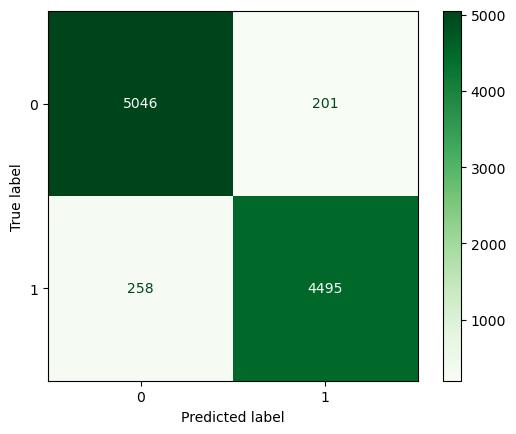

In [9]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

best_model_pred = best_model.predict(X_test)

print(f"Best Model's Accuracy score: {accuracy_score(y_test, best_model_pred)}")
print(f"Best Model's F1 score: {f1_score(y_test, best_model_pred)}")

matrix = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, best_model_pred))
matrix.plot(cmap='Greens')

This evaluates the classifier model on classifier-type evaluation metrics, such as accuracy, F1 scores, and a confusion matrix.

In [10]:
import joblib
from sklearn.metrics import classification_report
model_file_name = "mlp_best_model.joblib"

# Eval metrics to save
model_acc = accuracy_score(y_test, best_model_pred)
cm = confusion_matrix(y_test, best_model_pred)
model_report = classification_report(y_test, best_model_pred, output_dict=True)

model_results = {
    'model': best_model,
    'accuracy': model_acc,
    'classification_report': model_report,
    'confusion_matrix': cm
}

joblib.dump(model_results, model_file_name)

['mlp_best_model.joblib']

This allows us to save attributes of the best model and use them for our demo app.